In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from os.path import expanduser
import seaborn as sns
from cmcrameri import cm
from matplotlib import colors
import matplotlib.patches as patches

#### load the identifications from TFD/E and MaxQuant

In [3]:
IDENTS_MQ_DIR = '/media/big-ssd/experiments/P3856_YHE211/identifications-mq'
IDENTS_MQ_FILE = '{}/exp-P3856_YHE211-identifications-mq.feather'.format(IDENTS_MQ_DIR)

In [4]:
idents_mq_df = pd.read_feather(IDENTS_MQ_FILE)
idents_mq_df = idents_mq_df[idents_mq_df.isotope_count >= 3]

In [5]:
sequences_mq_l = []
for group_name,group_df in idents_mq_df.groupby(['sequence','charge'], as_index=False):
    perc_score = group_df['percolator score'].max()
    mass_accuracy_ppm = group_df.mass_accuracy_ppm.min()
    sequences_mq_l.append({'sequence_key':'{}-{}'.format(group_name[0], group_name[1]), 'perc_score':perc_score, 'mass_accuracy_ppm':mass_accuracy_ppm, 'method':'MaxQuant'})
sequences_mq_df = pd.DataFrame(sequences_mq_l)
print('MaxQuant identified {} unique sequences'.format(len(sequences_mq_df)))

MaxQuant identified 9166 unique sequences


In [6]:
IDENTS_TFDE_DIR = '/media/big-ssd/experiments/P3856_YHE211/identifications-pasef'
IDENTS_TFDE_FILE = '{}/exp-P3856_YHE211-identifications-pasef-recalibrated.feather'.format(IDENTS_TFDE_DIR)

In [7]:
idents_tfde_df = pd.read_feather(IDENTS_TFDE_FILE)

In [8]:
sequences_tfde_l = []
for group_name,group_df in idents_tfde_df.groupby(['sequence','charge'], as_index=False):
    perc_score = group_df['percolator score'].max()
    mass_accuracy_ppm = group_df.mass_accuracy_ppm.min()
    sequences_tfde_l.append({'sequence_key':'{}-{}'.format(group_name[0], group_name[1]), 'perc_score':perc_score, 'mass_accuracy_ppm':mass_accuracy_ppm, 'method':'TFD/E'})
sequences_tfde_df = pd.DataFrame(sequences_tfde_l)
print('TFD/E identified {} unique sequences'.format(len(sequences_tfde_df)))

TFD/E identified 11013 unique sequences


#### load the identifications from 3DID for various levels of intensity

In [9]:
counts_l = []
counts_l.append({'minvi':600,'name':'minvi-600-2021-12-19-02-35-34','hours':15.4})
counts_l.append({'minvi':1000,'name':'minvi-1000-2021-12-17-22-14-22','hours':12.5})
counts_l.append({'minvi':2000,'name':'minvi-2000-2021-12-17-03-11-51','hours':8.4})
counts_l.append({'minvi':3000,'name':'minvi-3000-2021-12-19-16-28-05','hours':6})
counts_l.append({'minvi':4000,'name':'minvi-4000-2021-12-20-00-08-59','hours':4.6})
counts_l.append({'minvi':5000,'name':'minvi-5000-2021-12-20-19-01-47','hours':3.6})
counts_df = pd.DataFrame(counts_l)

In [10]:
combined_results_d = {}
idents_in_common_d = {}
for result_set in counts_l:
    print('processing minvi={}'.format(result_set['minvi']))
    
    IDENTS_3DID_DIR = '/media/big-ssd/results-P3856_YHE211-3did/{}/P3856_YHE211/identifications-3did'.format(result_set['name'])
    IDENTS_3DID_FILE = '{}/exp-P3856_YHE211-identifications-3did-recalibrated.feather'.format(IDENTS_3DID_DIR)
    
    # load the 3DID results
    idents_3did_df = pd.read_feather(IDENTS_3DID_FILE)
    
    # find the unique sequences
    sequences_3did_l = []
    for group_name,group_df in idents_3did_df.groupby(['sequence','charge'], as_index=False):
        perc_score = group_df['percolator score'].max()
        mass_accuracy_ppm = group_df.mass_accuracy_ppm.min()
        sequences_3did_l.append({'sequence_key':'{}-{}'.format(group_name[0], group_name[1]), 'perc_score':perc_score, 'mass_accuracy_ppm':mass_accuracy_ppm, 'method':'3DID'})
    sequences_3did_df = pd.DataFrame(sequences_3did_l)

    # combine with the MaxQuant and TFD/E results
    combined_sequences_df = pd.concat([sequences_3did_df,sequences_mq_df,sequences_tfde_df], axis=0, sort=False, ignore_index=True)

    # prepare the results sets for the venn diagram
    sets_d = {'3DID':set(), 'MaxQuant':set(), 'TFD/E':set()}
    all_methods_l = []
    for group_name,group_df in combined_sequences_df.groupby(['sequence_key'], as_index=False):
        for method in group_df.method.tolist():
            sets_d[method].add(group_name)
        
        # find the sequences that are identified in all three methods
        if len(group_df) == 3:
            # percolator score
            score_3did = group_df[group_df.method=='3DID'].iloc[0].perc_score
            score_mq = group_df[group_df.method=='MaxQuant'].iloc[0].perc_score
            score_tfde = group_df[group_df.method=='TFD/E'].iloc[0].perc_score

            # mass accuracy ppm
            mass_accuracy_ppm_3did = group_df[group_df.method=='3DID'].iloc[0].mass_accuracy_ppm
            mass_accuracy_ppm_mq = group_df[group_df.method=='MaxQuant'].iloc[0].mass_accuracy_ppm
            mass_accuracy_ppm_tfde = group_df[group_df.method=='TFD/E'].iloc[0].mass_accuracy_ppm

            # add the attributes to the list
            all_methods_l.append({'sequence':group_name,'score_3did':score_3did,'score_mq':score_mq,'score_tfde':score_tfde,'mass_accuracy_ppm_3did':mass_accuracy_ppm_3did,'mass_accuracy_ppm_mq':mass_accuracy_ppm_mq,'mass_accuracy_ppm_tfde':mass_accuracy_ppm_tfde})
    all_methods_df = pd.DataFrame(all_methods_l)
    
    # store the results
    combined_results_d[result_set['minvi']] = sets_d
    idents_in_common_d[result_set['minvi']] = all_methods_df

processing minvi=600
processing minvi=1000
processing minvi=2000
processing minvi=3000
processing minvi=4000
processing minvi=5000


In [11]:
columns = 3
rows = int(len(counts_l) / columns)
if len(counts_l) % columns != 0:
    rows += 1

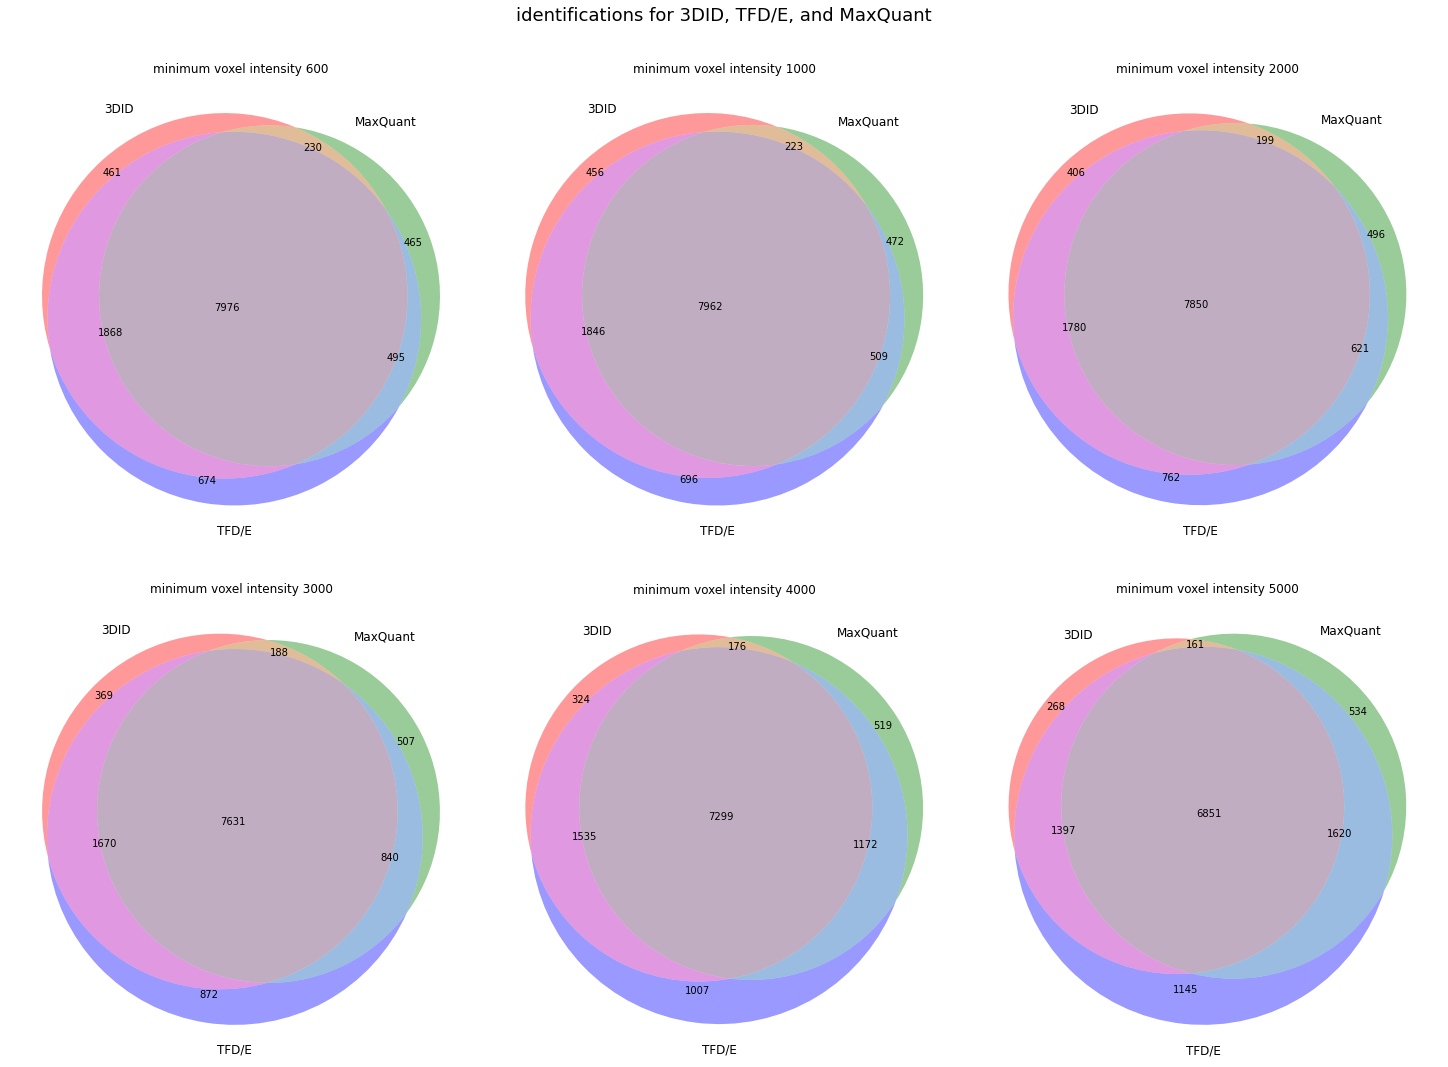

In [12]:
f, axarr = plt.subplots(nrows=rows, ncols=columns, constrained_layout=True)
f.set_figheight(15)
f.set_figwidth(20)
f.suptitle('identifications for 3DID, TFD/E, and MaxQuant\n', fontsize=18)

# turn off the axes if the last row is incomplete
if len(counts_l) % columns != 0:
    axarr[-1, -1].axis('off')

plt.margins(0.06)

for row_idx,result_set in enumerate(counts_l):
    r = int(row_idx / columns)
    c = row_idx % columns
    ax = axarr[r,c]  # row, column
    
    sets_d = combined_results_d[result_set['minvi']]

    ax.set_title('minimum voxel intensity {}'.format(result_set['minvi']))

    venn3([sets_d['3DID'],sets_d['MaxQuant'],sets_d['TFD/E']], ('3DID','MaxQuant','TFD/E'), ax=ax)

plt.show()

#### percolator score for identifications in common between 3DID and TFD/E

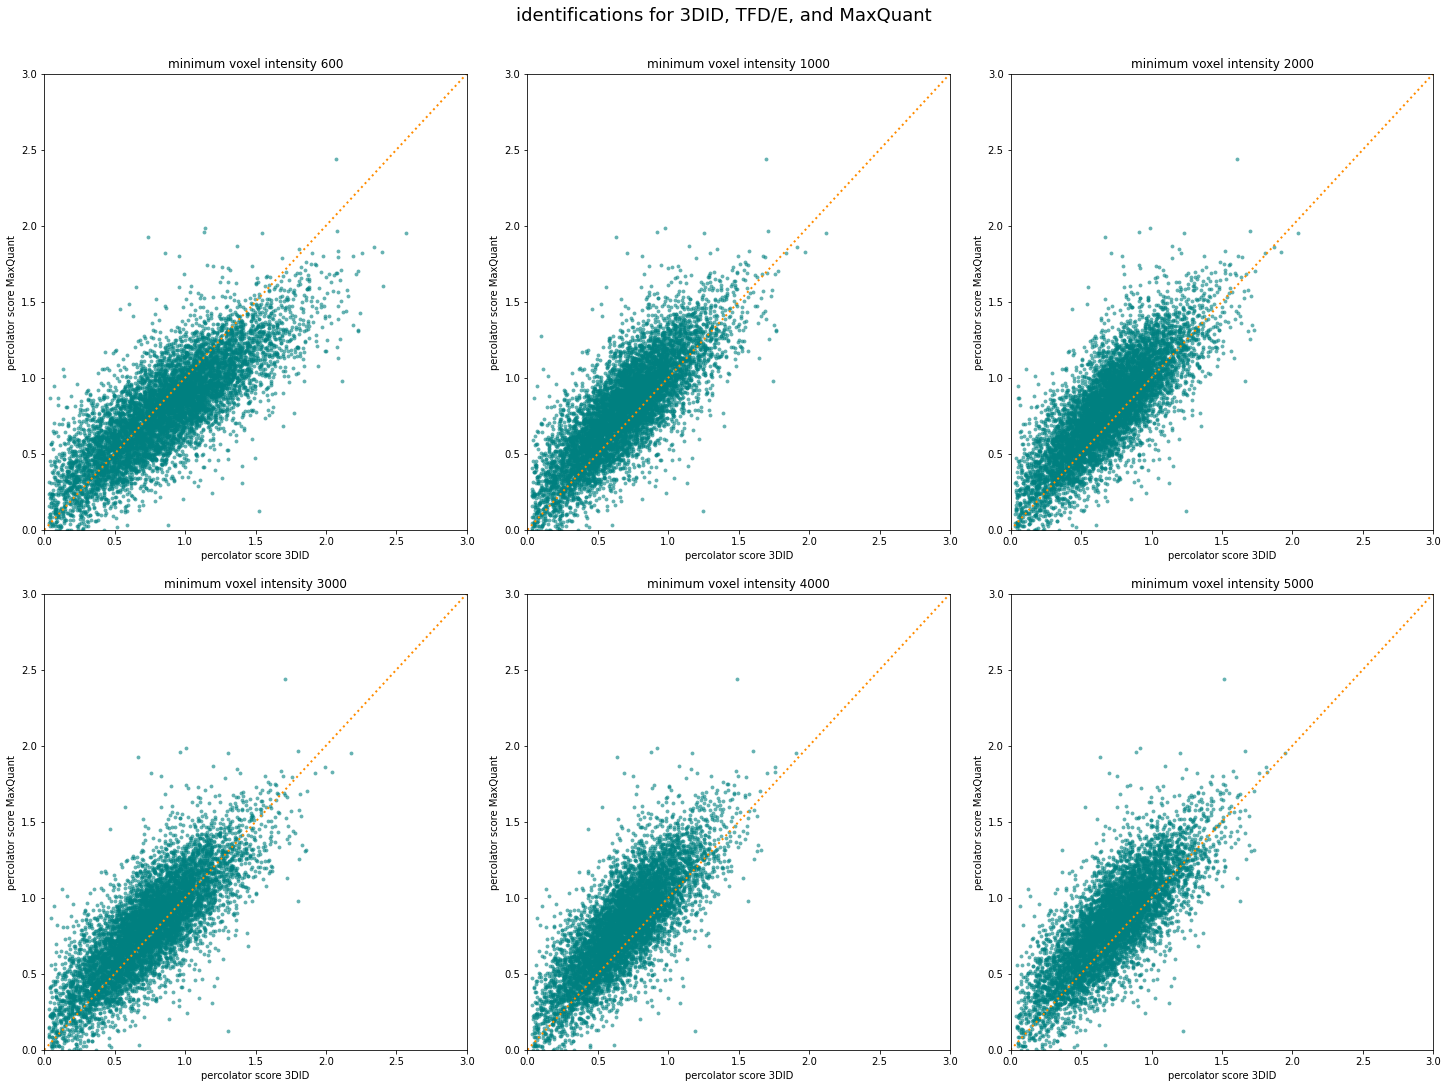

In [13]:
f, axarr = plt.subplots(nrows=rows, ncols=columns, constrained_layout=True)
f.set_figheight(15)
f.set_figwidth(20)
f.suptitle('identifications for 3DID, TFD/E, and MaxQuant\n', fontsize=18)

# turn off the axes if the last row is incomplete
if len(counts_l) % columns != 0:
    axarr[-1, -1].axis('off')

plt.margins(0.06)

for row_idx,result_set in enumerate(counts_l):
    r = int(row_idx / columns)
    c = row_idx % columns
    ax = axarr[r,c]  # row, column
    
    all_methods_df = idents_in_common_d[result_set['minvi']]

    ax.set_title('minimum voxel intensity {}'.format(result_set['minvi']))
    ax.scatter(all_methods_df.score_3did, all_methods_df.score_mq, c='teal', marker='o', lw=0, s=15, alpha=0.6)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle=':', linewidth=2, color='darkorange')
    
    ax.set_xlim((0,3))
    ax.set_ylim((0,3))
    
    ax.set_xlabel('percolator score 3DID')
    ax.set_ylabel('percolator score MaxQuant')

plt.show()

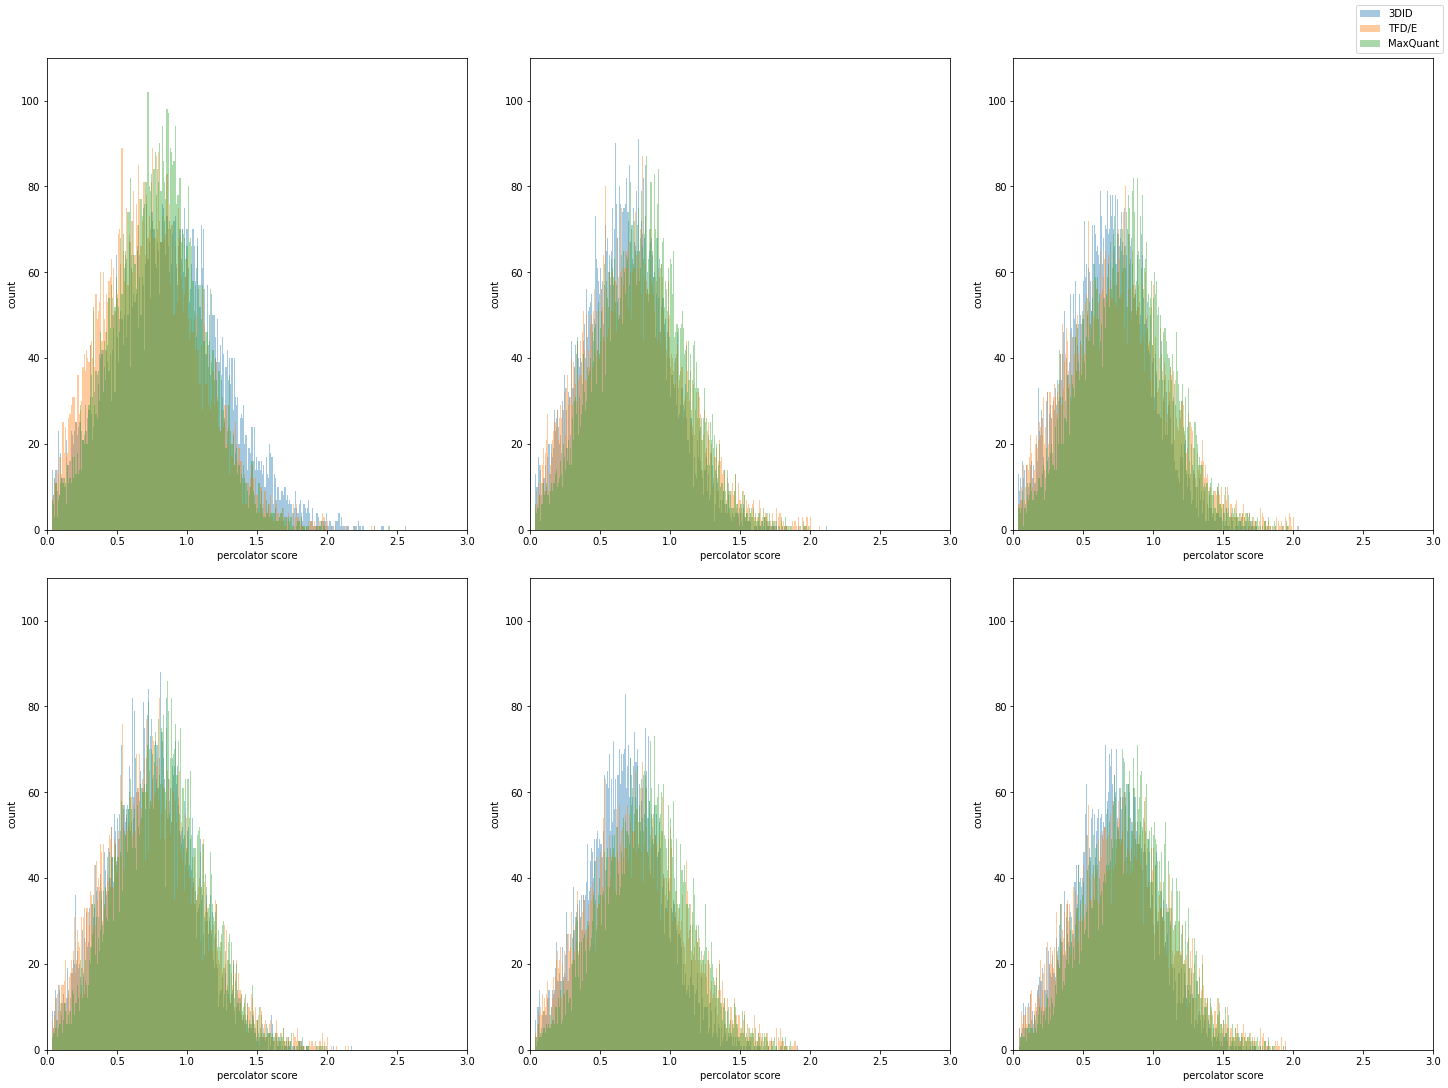

In [14]:
f, axarr = plt.subplots(nrows=rows, ncols=columns, constrained_layout=True)
f.set_figheight(15)
f.set_figwidth(20)
# f.suptitle('identifications for 3DID, TFD/E, and MaxQuant\n', fontsize=18)
f.suptitle(' \n', fontsize=18)

# turn off the axes if the last row is incomplete
if len(counts_l) % columns != 0:
    axarr[-1, -1].axis('off')

plt.margins(0.06)

for row_idx,result_set in enumerate(counts_l):
    r = int(row_idx / columns)
    c = row_idx % columns
    ax = axarr[r,c]  # row, column
    
    df = idents_in_common_d[result_set['minvi']]

    bins = 300
    hist, bins, _ = ax.hist(df.score_3did, bins=bins, alpha=0.4, label='3DID')
    hist, bins, _ = ax.hist(df.score_tfde, bins=bins, alpha=0.4, label='TFD/E')
    hist, bins, _ = ax.hist(df.score_mq, bins=bins, alpha=0.4, label='MaxQuant')
    
    ax.set_xlim((0,3))
    ax.set_ylim((0,110))

    ax.set_xlabel('percolator score')
    ax.set_ylabel('count')

handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels, loc='upper right')

plt.show()

#### mass accuracy ppm

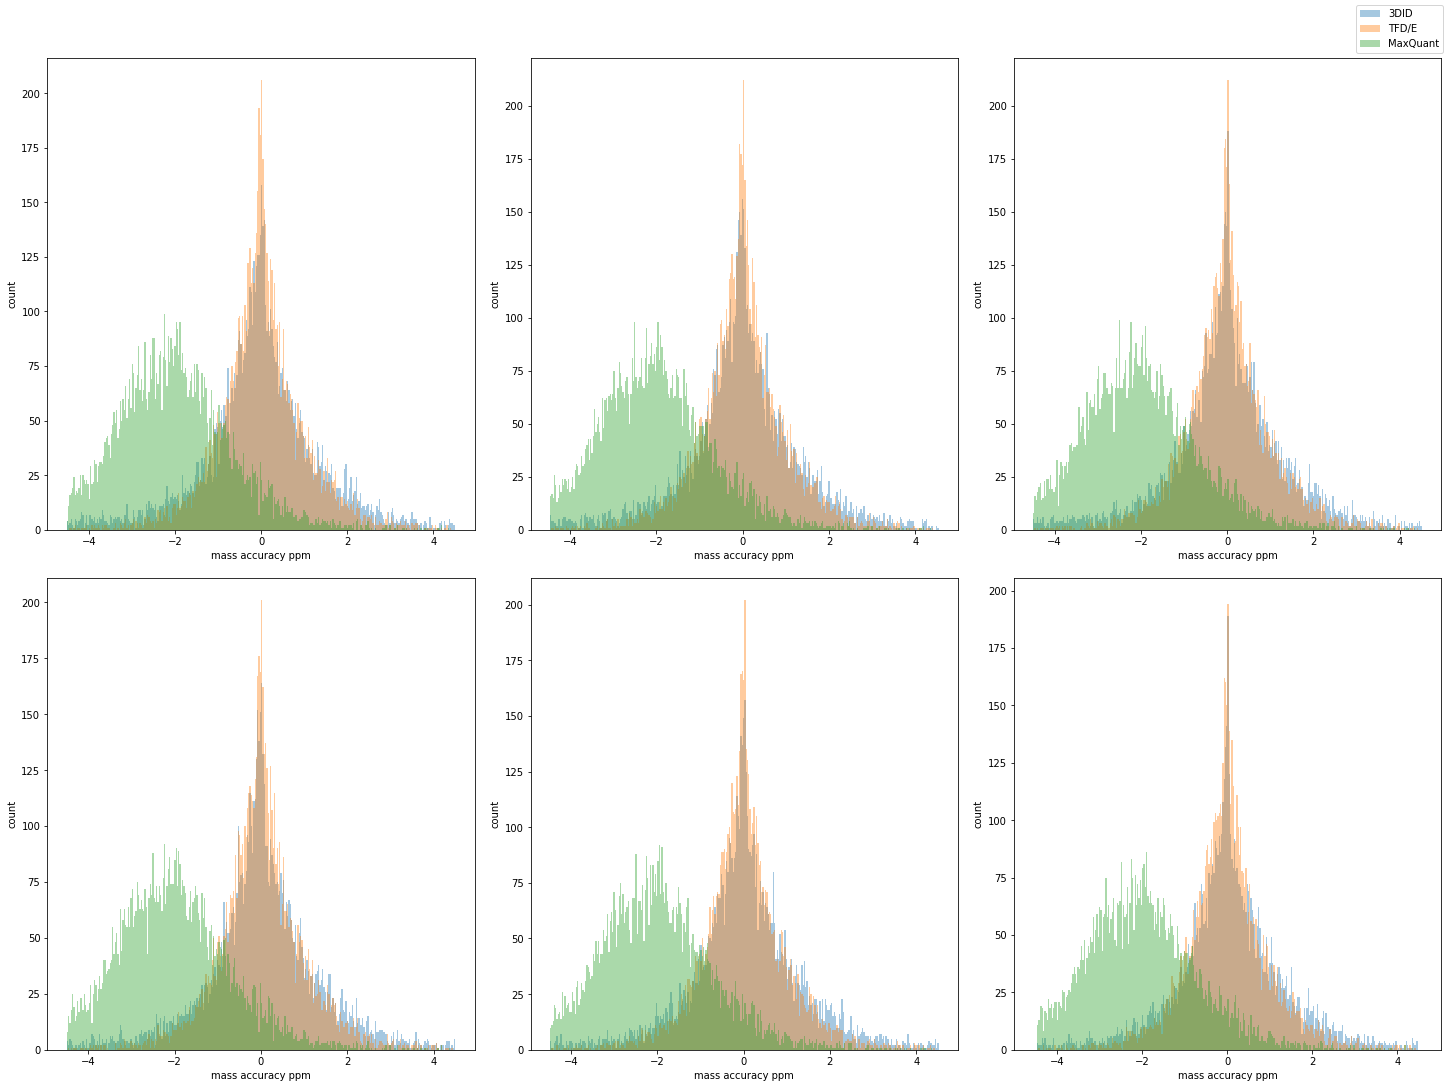

In [15]:
f, axarr = plt.subplots(nrows=rows, ncols=columns, constrained_layout=True)
f.set_figheight(15)
f.set_figwidth(20)
# f.suptitle('identifications for 3DID, TFD/E, and MaxQuant\n', fontsize=18)
f.suptitle(' \n', fontsize=18)

# turn off the axes if the last row is incomplete
if len(counts_l) % columns != 0:
    axarr[-1, -1].axis('off')

plt.margins(0.06)

for row_idx,result_set in enumerate(counts_l):
    r = int(row_idx / columns)
    c = row_idx % columns
    ax = axarr[r,c]  # row, column
    
    df = idents_in_common_d[result_set['minvi']]

    bins = 300
    hist, bins, _ = ax.hist(df.mass_accuracy_ppm_3did, bins=bins, alpha=0.4, label='3DID')
    hist, bins, _ = ax.hist(df.mass_accuracy_ppm_tfde, bins=bins, alpha=0.4, label='TFD/E')
    hist, bins, _ = ax.hist(df.mass_accuracy_ppm_mq, bins=bins, alpha=0.4, label='MaxQuant')

    ax.set_xlabel('mass accuracy ppm')
    ax.set_ylabel('count')

handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels, loc='upper right')

plt.show()

#### features detected vs identified

In [16]:
for result_set in counts_l:
    print('processing minvi={}'.format(result_set['minvi']))
    
    IDENTS_3DID_DIR = '/media/big-ssd/results-P3856_YHE211-3did/{}/P3856_YHE211/identifications-3did'.format(result_set['name'])
    IDENTS_3DID_FILE = '{}/exp-P3856_YHE211-identifications-3did-recalibrated.feather'.format(IDENTS_3DID_DIR)
    
    identifications_df = pd.read_feather(IDENTS_3DID_FILE)
    identified_feature_ids = set(identifications_df.feature_id.to_list())

    DETECTS_3DID_DIR = '/media/big-ssd/results-P3856_YHE211-3did/{}/P3856_YHE211/features-3did'.format(result_set['name'])
    DETECTS_3DID_FILE = '{}/exp-P3856_YHE211-run-P3856_YHE211_1_Slot1-1_1_5104-features-3did-dedup.feather'.format(DETECTS_3DID_DIR)
    
    detections_df = pd.read_feather(DETECTS_3DID_FILE)
    detected_feature_ids = set(detections_df.feature_id.to_list())

    DETECTS_WITHIN_ISOL_3DID_DIR = '/media/big-ssd/results-P3856_YHE211-3did/{}/P3856_YHE211/features-3did'.format(result_set['name'])
    DETECTS_WITHIN_ISOL_3DID_FILE = '{}/exp-P3856_YHE211-run-P3856_YHE211_1_Slot1-1_1_5104-features-3did-assoc.feather'.format(DETECTS_WITHIN_ISOL_3DID_DIR)
    
    detections_within_isol_df = pd.read_feather(DETECTS_WITHIN_ISOL_3DID_FILE)
    detected_in_isol_feature_ids = set(detections_within_isol_df.feature_id.to_list())  # this will have dups of feature ids that occur in more than one isolation window
    
    detections_df['in_isolation_window'] = detections_df.feature_id.isin(detected_in_isol_feature_ids)
    detections_df['identified'] = detections_df.feature_id.isin(identified_feature_ids)
    
    result_set['number_detected'] = len(detected_feature_ids)
    result_set['number_detected_in_isolation_windows'] = len(detected_in_isol_feature_ids)
    result_set['number_identified'] = len(identified_feature_ids)
    result_set['sensitivity'] = result_set['number_identified'] / result_set['number_detected_in_isolation_windows']
    result_set['percent_all_features'] = result_set['number_detected_in_isolation_windows'] / result_set['number_detected']
    
    result_set['detections_df'] = detections_df[['feature_id','feature_intensity','charge','in_isolation_window','identified']]

processing minvi=600
processing minvi=1000
processing minvi=2000
processing minvi=3000
processing minvi=4000
processing minvi=5000


In [17]:
results_df = pd.DataFrame(counts_l)

In [18]:
results_df

,minvi,name,hours,number_detected,number_detected_in_isolation_windows,number_identified,sensitivity,percent_all_features,detections_df
0,600,minvi-600-2021-12-19-02-35-34,15.4,156244,86176,14384,0.166914,0.551548,feature_id feature_intensity charge ...
1,1000,minvi-1000-2021-12-17-22-14-22,12.5,147652,80791,14022,0.173559,0.547172,feature_id feature_intensity charge ...
2,2000,minvi-2000-2021-12-17-03-11-51,8.4,125264,67176,13173,0.196097,0.536275,feature_id feature_intensity charge ...
3,3000,minvi-3000-2021-12-19-16-28-05,6.0,103403,54239,12328,0.227290,0.524540,feature_id feature_intensity charge ...
4,4000,minvi-4000-2021-12-20-00-08-59,4.6,85081,43591,11452,0.262715,0.512347,feature_id feature_intensity charge ...
5,5000,minvi-5000-2021-12-20-19-01-47,3.6,70606,35498,10481,0.295256,0.502762,feature_id feature_intensity charge ...


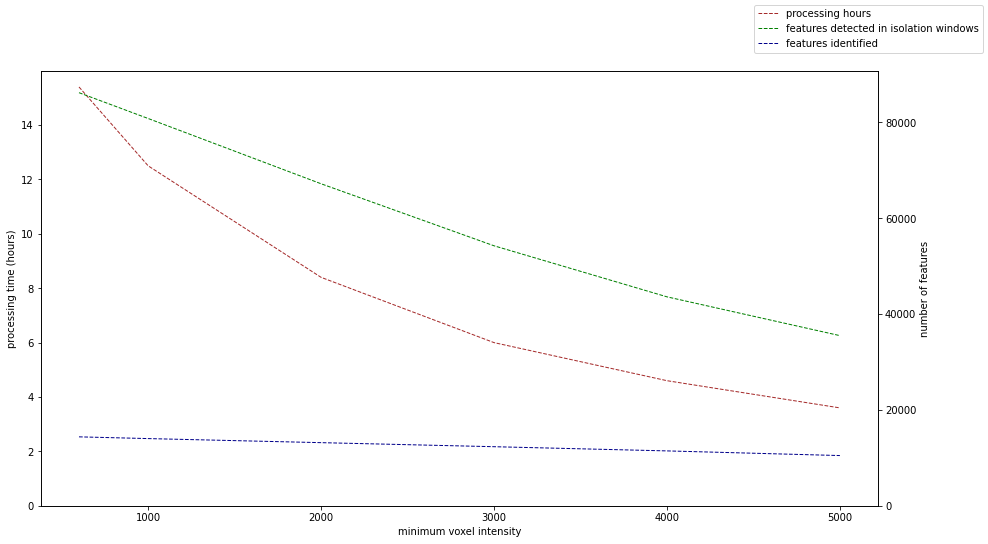

In [28]:
f, ax1 = plt.subplots()
ax2 = ax1.twinx()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the smoothed points
ax1.plot(results_df.minvi, results_df.hours, marker='', color='brown', linestyle='--', linewidth=1, ms=5, label='processing hours')
ax2.plot(results_df.minvi, results_df.number_detected_in_isolation_windows, marker='', color='green', linestyle='--', linewidth=1, ms=5, label='features detected in isolation windows')
ax2.plot(results_df.minvi, results_df.number_identified, marker='', color='darkblue', linestyle='--', linewidth=1, ms=5, label='features identified')

# plt.title('processing time and number of de-duped features by minimum voxel intensity')
f.legend()
ax1.set_xlabel("minimum voxel intensity")
ax1.set_ylabel("processing time (hours)")
ax1.set_ylim(0,)
ax2.set_ylabel("number of features")
ax2.set_ylim(0,)
plt.show()

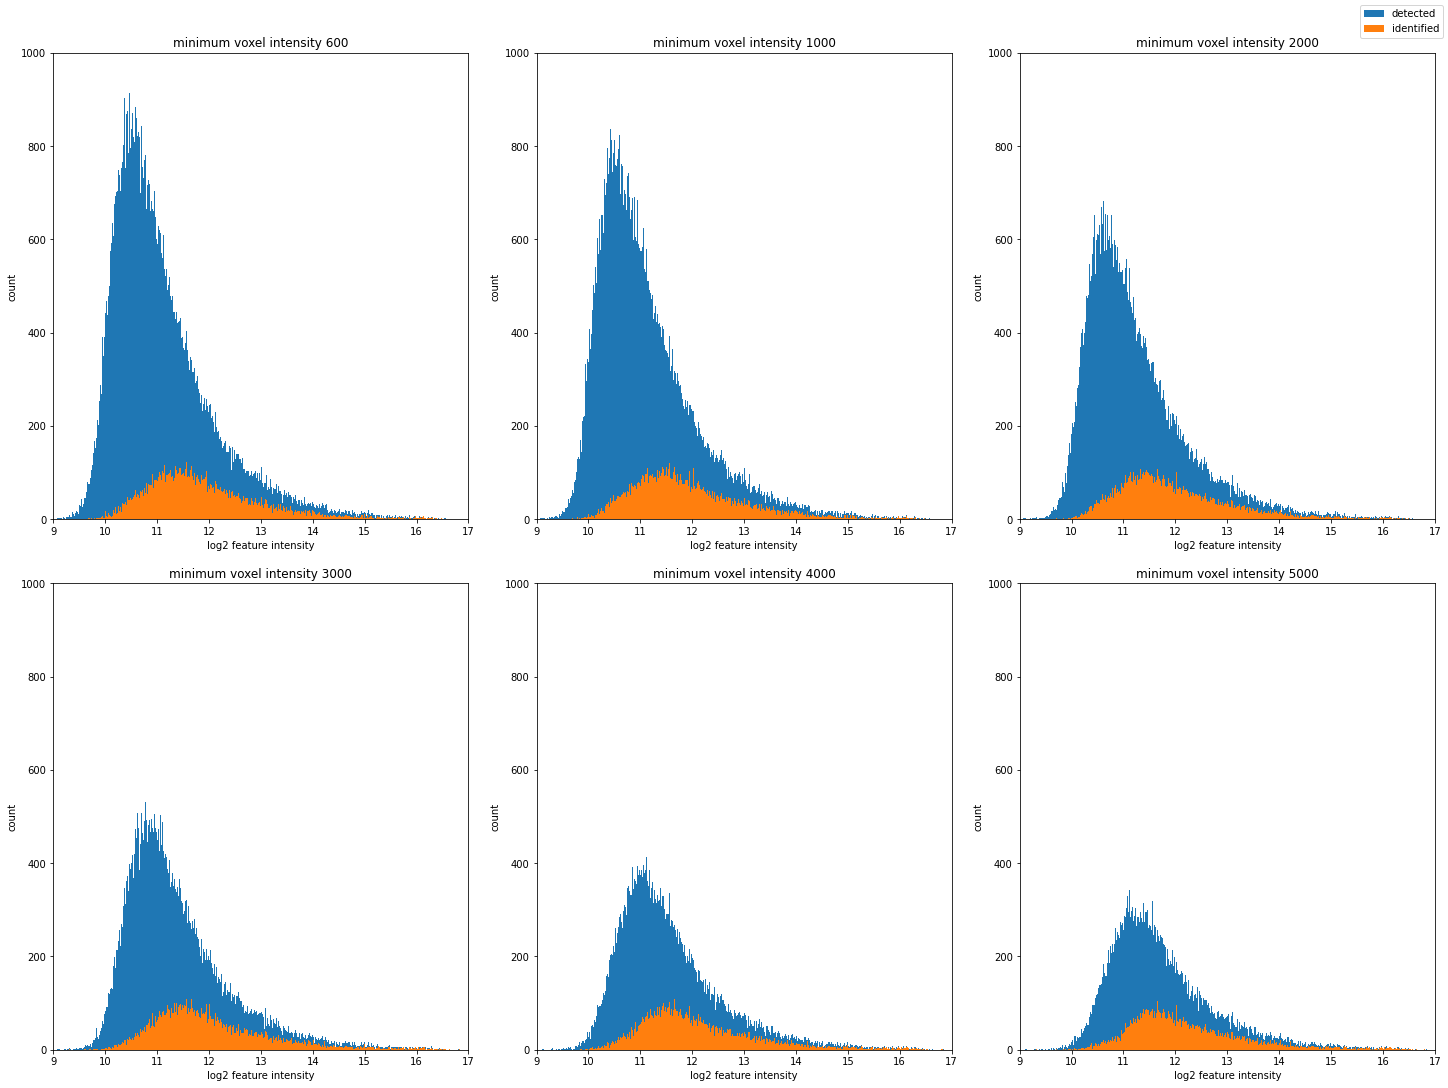

In [21]:
f, axarr = plt.subplots(nrows=rows, ncols=columns, constrained_layout=True)
f.set_figheight(15)
f.set_figwidth(20)
# f.suptitle('detections and identifications', fontsize=18)
f.suptitle(' ', fontsize=18)

# turn off the axes if the last row is incomplete
if len(counts_l) % columns != 0:
    axarr[-1, -1].axis('off')

plt.margins(0.06)

for row_idx,result_set in enumerate(counts_l):
    r = int(row_idx / columns)
    c = row_idx % columns
    ax = axarr[r,c]  # row, column
    
    detections_df = result_set['detections_df']
    detections_in_isol_df = detections_df[detections_df.in_isolation_window == True]
    identified_df = detections_df[detections_df.identified == True]
    
    bins = 500
    values = np.log2(detections_in_isol_df.feature_intensity)
    y, x, _ = ax.hist(values, bins=bins, label='detected')

    values = np.log2(identified_df.feature_intensity)
    y, x, _ = ax.hist(values, bins=bins, label='identified')

    ax.set_title('minimum voxel intensity {}'.format(result_set['minvi']))
    ax.set_xlim((9,17))
    ax.set_ylim((0,1000))
    
    ax.set_xlabel('log2 feature intensity')
    ax.set_ylabel('count')

handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels, loc='upper right')
    
plt.show()

#### all features versus those in isolation windows

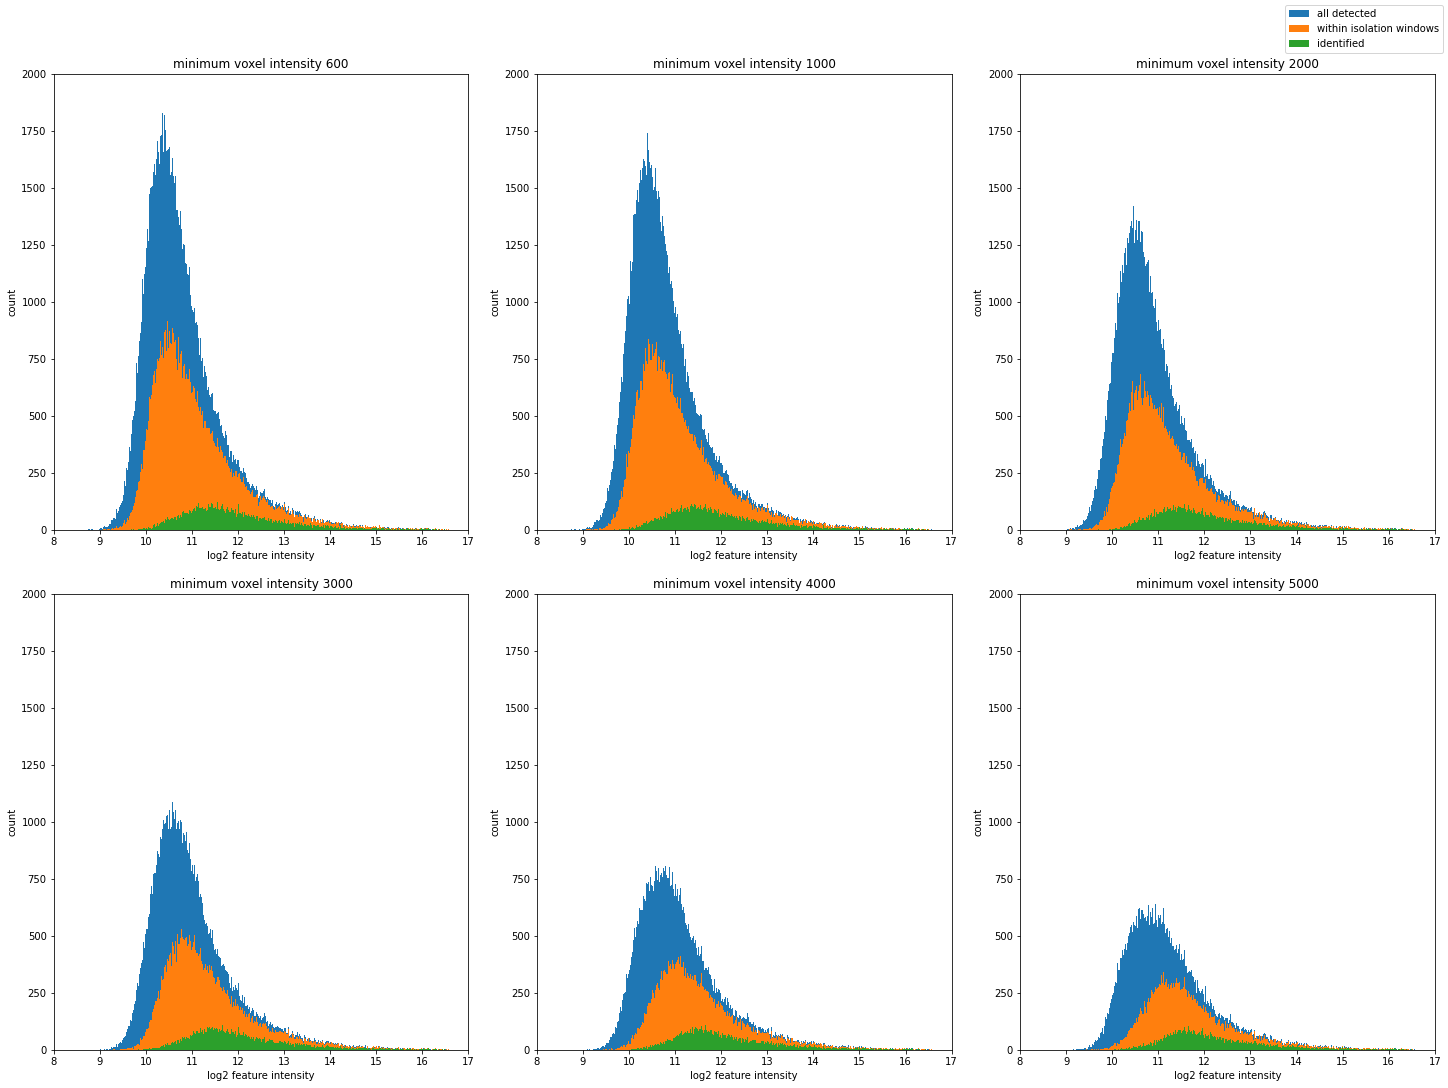

In [22]:
f, axarr = plt.subplots(nrows=rows, ncols=columns, constrained_layout=True)
f.set_figheight(15)
f.set_figwidth(20)
# f.suptitle('detections and identifications', fontsize=18)
f.suptitle(' \n', fontsize=18)

# turn off the axes if the last row is incomplete
if len(counts_l) % columns != 0:
    axarr[-1, -1].axis('off')

plt.margins(0.06)

for row_idx,result_set in enumerate(counts_l):
    r = int(row_idx / columns)
    c = row_idx % columns
    ax = axarr[r,c]  # row, column
    
    detections_df = result_set['detections_df']
    detections_in_isol_df = detections_df[detections_df.in_isolation_window == True]
    identified_df = detections_df[detections_df.identified == True]
    
    bins = 500
    values = np.log2(detections_df.feature_intensity)
    y, x, _ = ax.hist(values, bins=bins, label='all detected')

    values = np.log2(detections_in_isol_df.feature_intensity)
    y, x, _ = ax.hist(values, bins=bins, label='within isolation windows')

    values = np.log2(identified_df.feature_intensity)
    y, x, _ = ax.hist(values, bins=bins, label='identified')

    ax.set_title('minimum voxel intensity {}'.format(result_set['minvi']))
    ax.set_xlim((8,17))
    ax.set_ylim((0,2000))
    
    ax.set_xlabel('log2 feature intensity')
    ax.set_ylabel('count')

handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels, loc='upper right')
    
plt.show()

#### charge states (all detected)

In [23]:
max_charge = 0
for row_idx,result_set in enumerate(counts_l):
    detections_df = result_set['detections_df']
    max_charge = max(max_charge,detections_df.charge.max())

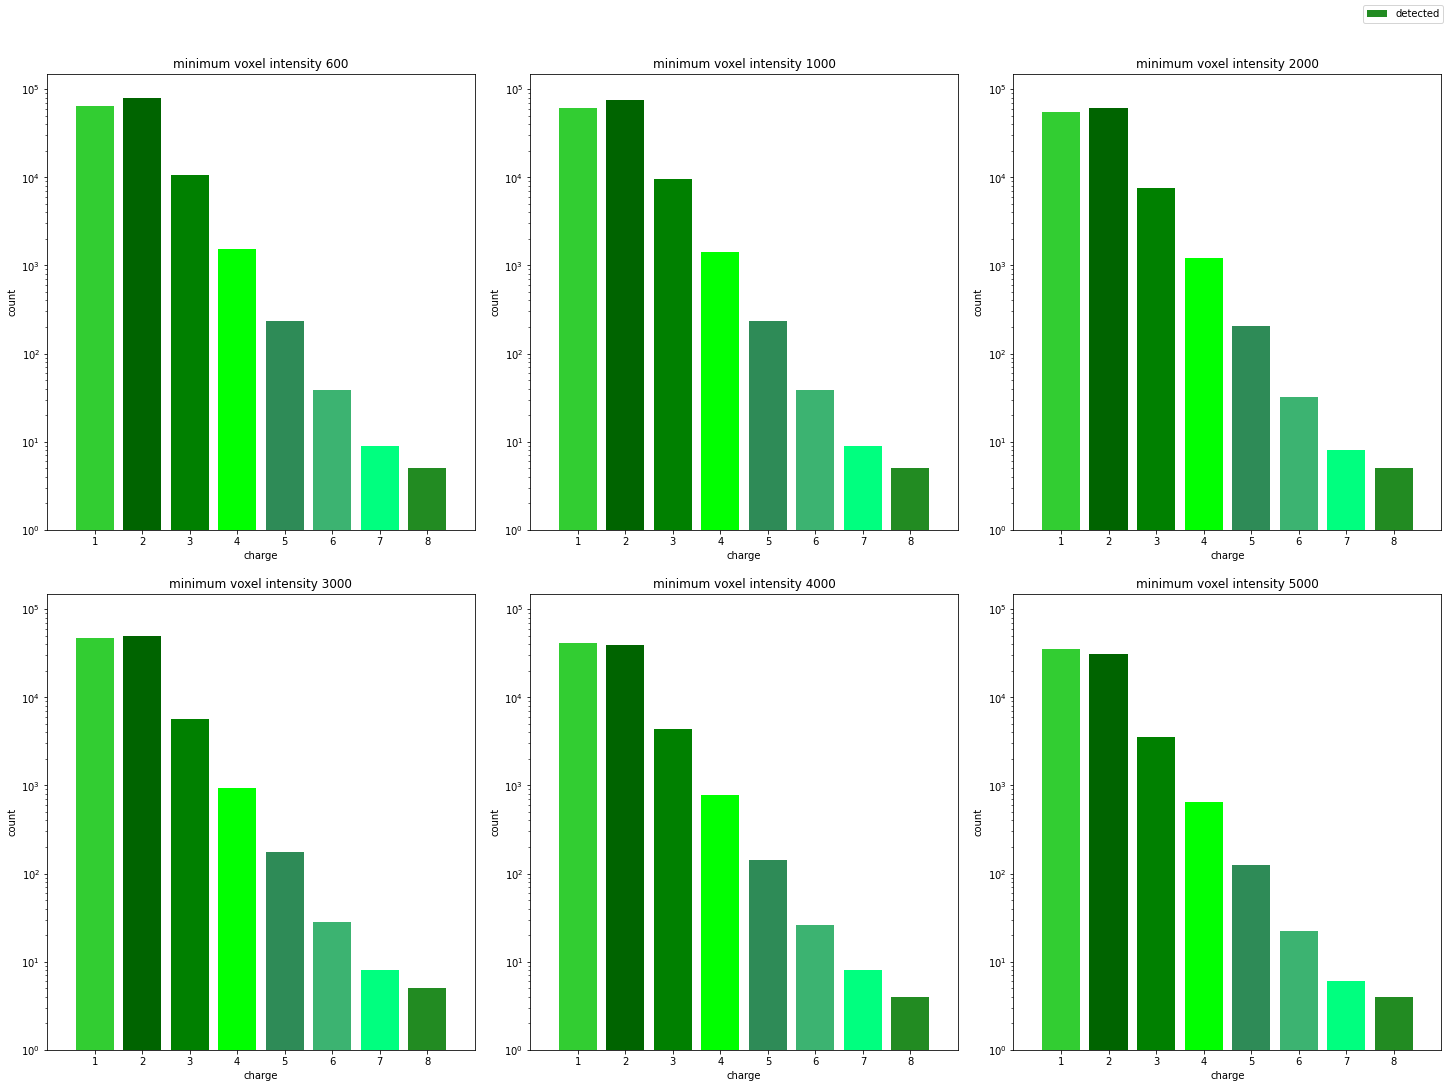

In [40]:
f, axarr = plt.subplots(nrows=rows, ncols=columns, constrained_layout=True)
f.set_figheight(15)
f.set_figwidth(20)
# f.suptitle('detections and identifications', fontsize=18)
f.suptitle(' \n', fontsize=18)

# turn off the axes if the last row is incomplete
if len(counts_l) % columns != 0:
    axarr[-1, -1].axis('off')

plt.margins(0.06)

for row_idx,result_set in enumerate(counts_l):
    r = int(row_idx / columns)
    c = row_idx % columns
    ax = axarr[r,c]  # row, column
    
    detections_df = result_set['detections_df']
    
    counts = np.bincount(detections_df.charge)
    ax.bar(range(max_charge+1), counts, width=0.8, align='center', color=['forestgreen','limegreen','darkgreen','green','lime','seagreen','mediumseagreen','springgreen'], label='detected', log=True)
    ax.set_xlabel('charge')
    ax.set_ylabel('count')
    ax.set(xticks=range(1,max_charge+1), xlim=[0,max_charge+1])
    ax.set_ylim((1,150000))

    ax.set_title('minimum voxel intensity {}'.format(result_set['minvi']))

handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels, loc='upper right')
    
plt.show()

#### number of isotopes